# Traversal Distance Dataset Analysis

In [1]:
# standard library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from itertools import chain
from scipy import stats


# local classes
os.chdir('../')
from TraversalDistance.Graph import Graph
from TraversalDistance.FreeSpaceGraph import FreeSpaceGraph
from TraversalDistance.Visualize import Visualize
from TraversalDistance.BinarySearch import BinarySearch
from TraversalDistance.DistanceMatrix import DistanceMatrix
os.chdir('leaf_data')

### Importing lead dataset at Pandas DataFrame. 

In [2]:
df = pd.read_csv('maracuya.csv')
df = df.drop(columns=['plant', 'ontogeny', 'total'])

# divide species into seven classes based on the paper
# https://academic.oup.com/gigascience/article/6/1/giw008/2865207?login=true#supplementary-data
species_classes = {'miniata':6,
    'amethystina':3,
    'alata':5,
    'rubra':1,
    'misera':0,
    'setacea':2,
    'triloba':4,
    'nitida':5,
    'actinia':4,
    'villosa':5,
    'micropetala':1,
    'mucronata':6,
    'maliformis':6,
    'miersii':4,
    'malacophylla':6,
    'gibertii':2,
    'mollissima':2,
    'caerulea':2,
    'gracilis':3,
    'foetida':3,
    'racemosa':5,
    'tenuifila':2,
    'cristalina':6,
    'ligularis':5,
    'cincinnata':2,
    'coccinea':6,
    'hatschbachii':2,
    'morifolia':3,
    'organensis':1,
    'capsularis':1,
    'edmundoi':2,
    'galbana':6,
    'tricuspis':1,
    'pohlii':1,
    'biflora':1,
    'sidifolia':4,
    'suberosa':2,
    'edulis':5,
    'coriacea':0,
    'kermesina':2}

# replace species names with class in dataset
df['species_classes'] = df['species'].map(species_classes)


# dropping outlying heteroblasty values
lower_bound = df['heteroblasty'].quantile(0.80)
upper_bound = df['heteroblasty'].quantile(0.90)
df = df[(df['heteroblasty'] >= lower_bound) & (df['heteroblasty'] <= upper_bound)]

#printing dataframe head
df.head()

,species,heteroblasty,x1,y1,x2,y2,x3,y3,x4,y4,...,y11,x12,y12,x13,y13,x14,y14,x15,y15,species_classes
2,actinia,15,-43.242816,430.053913,-39.277936,409.976781,-34.239161,376.468073,4.770596,377.631881,...,-1462.301694,546.694706,-517.910591,557.727421,-406.283139,488.911001,155.339518,460.348932,210.137903,4
3,actinia,14,-36.082509,416.832663,-30.527203,394.236217,-19.829324,359.869763,13.246641,361.064598,...,-1385.313503,535.019483,-519.980964,617.977373,-346.868643,517.511348,207.452944,483.026127,261.141674,4
4,actinia,13,-7.724386,362.852233,-18.024917,347.266408,-16.965580,316.096657,18.166718,313.986527,...,-1493.947554,572.248040,-473.575088,591.964194,-391.158971,440.811250,275.545461,392.206108,308.648330,4
17,actinia,14,-44.918266,393.241955,-56.996588,374.975493,-26.231109,360.611771,28.656493,325.944374,...,-1544.337476,581.284358,-403.004684,599.540556,-302.987351,469.789777,196.915193,426.293825,265.674601,4
18,actinia,13,-11.965128,345.150805,-12.446094,328.081630,-6.230564,303.243904,43.021996,288.773927,...,-1598.088328,593.203274,-273.829452,594.560801,-207.874561,485.547020,190.654361,434.937213,239.824699,4


### Transforming leaf observations from DataFrame into geometric graph objects (Graph.py).

In [3]:
# edges to build graph
edges = {(1, 2),
    (2, 3),
    (3, 4),
    (4, 5),
    (5, 6),
    (6, 1),
    (1, 7),
    (2, 7),
    (2, 9),
    (3, 9),
    (3, 11),
    (4, 11),
    (4, 13),
    (5, 13),
    (5, 15),
    (6, 15),
    (7, 8),
    (8, 9),
    (9, 10),
    (10, 11),
    (11, 12),
    (12, 13),
    (13, 14),
    (14, 15)
}

x_headers = [f'x{i}' for i in range(1, 16)]
y_headers = [f'y{i}' for i in range(1, 16)]

# function to convert observation into Graph object
def row_to_graph(row):
    x_row, y_row = row[x_headers], row[y_headers]     
    graph = Graph()
    graph.name = row['species']

    for i, (x_header, y_header) in enumerate(zip(x_headers, y_headers), 1):
        x, y = x_row[x_header], y_row[y_header]
        graph.addNode(i, x, y)
        
    for i, edge in enumerate(edges, 1):
        graph.connectTwoNodes(i, edge[0], edge[1])
            
    return graph

### Testing Traversal Distance (FreeSpaceGraph.py) on first two observations from DataFrame.  

In [4]:
# First two observation example. 
row_1, row_2 = df.iloc[0], df.iloc[1]
graph_1, graph_2 = row_to_graph(row_1), row_to_graph(row_2)

# comparing two identical graphs
binary_search = BinarySearch(graph_1, graph_1, left=0, right=1000, precision=10)
epsilon = binary_search.search()
print("Computing graph_1 by graph_1 (traversed) minimum epsilon:", epsilon)

# comparing graph two and graph one
binary_search = BinarySearch(graph_2, graph_1, left=0, right=1000, precision=10)
epsilon = binary_search.search()
print("Computing graph_2 by graph_1 (traversed) minimum epsilon:", epsilon)

# comparing graph one and graph two
binary_search = BinarySearch(graph_1, graph_2, left=0, right=1000, precision=10)
epsilon = binary_search.search()
print("Computing graph_1 by graph_2 (traversed) minimum epsilon:", epsilon)

Computing graph_1 by graph_1 (traversed) minimum epsilon: 7.8125
Computing graph_2 by graph_1 (traversed) minimum epsilon: 367.1875
Computing graph_1 by graph_2 (traversed) minimum epsilon: 187.5


### Visualizing Free Space Diagram between first two observations. 

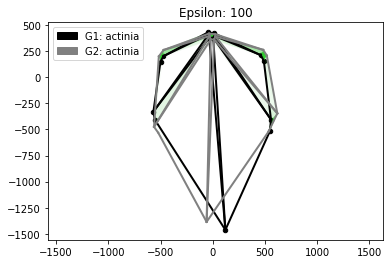

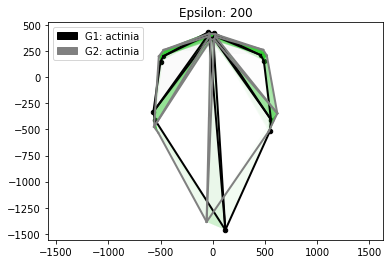

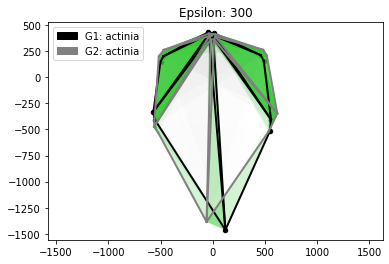

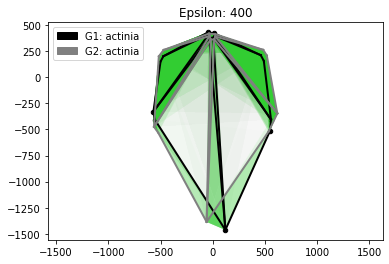

In [10]:
for epsilon in range(100, 500, 100):
    visual = Visualize(graph_1, graph_2, epsilon=epsilon)
    visual.plot_freespace()

### Comparing Distances across 2 classes.

In [6]:
def rows_to_graphs(df, n=None):
    graphs = list() 
    if n: df = df.head(n)
    for index, row in df.iterrows():
        graph = row_to_graph(row)
        graphs.append(graph)
    return graphs

def distance_matrix(graphs_n, graphs_m, left=0, right=1000, precision=10):
    epsilons = list()
    for graph_m in graphs_m:
        epsilons.append(list())
        for graph_n in graphs_n:
            epsilon_x = BinarySearch(graph_m, graph_n, left=left, right=right, precision=precision).search()
            epsilon_y = BinarySearch(graph_n, graph_m, left=left, right=right, precision=precision).search()
            epsilons[-1].append((epsilon_x, epsilon_y))
    return epsilons
    
def scatter_plot(xy_1, xy_2, class_1, class_2):
    x_1, y_1 = zip(*xy_1)
    x_2, y_2 = zip(*xy_2)
    label_1 = f"C1: {class_1} | C2: {class_1}"
    label_2 = f"C1: {class_1} | C2: {class_2}"
    
    plt.scatter(x_1, y_1, c='blue', marker='o', label=label_1, alpha=0.5, s=15)
    plt.scatter(x_2, y_2, c='red', marker='o', label=label_2, alpha=0.5, s=15)   

    plt.title('Traversal Distances for Two Classifications')
    plt.ylabel(f'Minium Epsilon (C1 Traversed)')
    plt.xlabel(f'Minium Epsilon (C2 Traversed)')

    plt.legend()
    plt.show()

In [7]:
class_1_df = df[df['species'] == 'actinia']
class_1_graphs = rows_to_graphs(class_1_df, n=5)

class_2_df = df[df['species'] == 'cristalina']
class_2_graphs = rows_to_graphs(class_2_df, n=5)

In [8]:
class_1_1_matrix = DistanceMatrix(class_1_graphs, class_1_graphs)
class_1_2_matrix = DistanceMatrix(class_1_graphs, class_2_graphs)

class_1_1_matrix.compute()
class_1_2_matrix.compute()

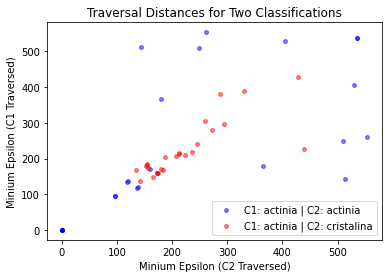

In [9]:
class_1_1_list = class_1_1_matrix.to_list()
class_1_2_list = class_1_2_matrix.to_list()
scatter_plot(class_1_1_list, class_1_2_list, 'actinia', 'cristalina')